In [ ]:
%load_ext autoreload
%autoreload 2

# Develop CT-RNN animation
The purpose of this notebook is to visualize the dynamics of a CT-RNN computing the ModularArithmeticTask via a Plotly animation.

## Imports

In [2]:
import json
import os
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

import jax.numpy as jnp
from jax import random
from flax import linen as nn
from modularRNN.model import CTRNNCell
from modularRNN.task import ModularArithmeticTask
from modularRNN.training import create_train_state, ModelParameters

from sklearn.decomposition import PCA

from functools import partial

In [3]:
import plotly.graph_objects as go
import plotly.io as pio
pio.templates['plotly'].layout['autosize'] = False

## Graphs of interest

In [4]:
hyperparameter_search = 'hyperparameter_2'
task_id = 'task_207'

params_for_json = f"../data/{hyperparameter_search}/{task_id}/params.json"
example_csv = f"../data/{hyperparameter_search}/{task_id}/metrics_history.csv"
model_params_save = f"../data/{hyperparameter_search}/{task_id}/test_params.bin"

with open(params_for_json, 'r') as f:
    json_params = json.load(f)

seed = json_params.get('seed', 0)
alpha = json_params.get('alpha', 0.1)
noise = json_params.get('noise', 0.05)
pulse_mean = json_params.get('pulse_mean', 12)
mod_set = json_params.get('mod_set', [5,])
training_trials = json_params.get('training_trials', 3200)
testing_trials = json_params.get('testing_trials', 640)
train_batch_size = json_params.get('train_batch_size', 128)
lr = json_params.get('lr', 0.001)
epochs = json_params.get('epochs', 500)
weight_decay = json_params.get('weight_decay', 0.0001)
l2_penalty = json_params.get('l2_penalty', 0.0001)
trial_length = json_params.get('trial_length', 100)

key = random.PRNGKey(seed)

In [5]:
mod_set = jnp.array(mod_set)
pulse_distribution = partial(random.poisson, lam=pulse_mean)

key, subkey = random.split(key)
modtask = ModularArithmeticTask(
    subkey, 
    training_trials, 
    testing_trials, 
    train_batch_size, 
    mod_set, 
    pulse_distribution, 
    trial_length,
)
training_dataset, testing_dataset = modtask.tf_datasets()

features = 100
alpha = jnp.float32(alpha)
noise = jnp.float32(noise)

ctrnn = nn.RNN(CTRNNCell(features=features, alpha=alpha, noise=noise, out_shape=10,))

key, subkey = random.split(key)
state = create_train_state(ctrnn, subkey, lr, weight_decay, trial_length)

model_params = ModelParameters(state)
model_params.deserialize(model_params_save,)

100%|███████████████████████████████████████| 640/640 [00:00<00:00, 1004.49it/s]


In [6]:
inputs_list = []
labels_list = []
rates_list = []
outputs_list = []

for _inputs, _labels in tqdm(training_dataset.as_numpy_iterator()):
    key, subkey = random.split(key)
    _outputs, _rates = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

    inputs_list.append(_inputs)
    labels_list.append(_labels)
    rates_list.append(_rates)
    outputs_list.append(_outputs)

inputs_ = jnp.concatenate(inputs_list, axis=0)
labels_ = jnp.concatenate(labels_list, axis=0)
rates_ = jnp.concatenate(rates_list, axis=0)
outputs_ = jnp.concatenate(outputs_list, axis=0)

rates_shape = rates_.shape

rates_reshaped = rates_.reshape(-1, rates_shape[-1])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(rates_reshaped)

reshaped_pc = principal_components.reshape(rates_shape[0], rates_shape[1], 2)

50it [00:09,  5.38it/s]2024-04-06 18:51:32.387881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



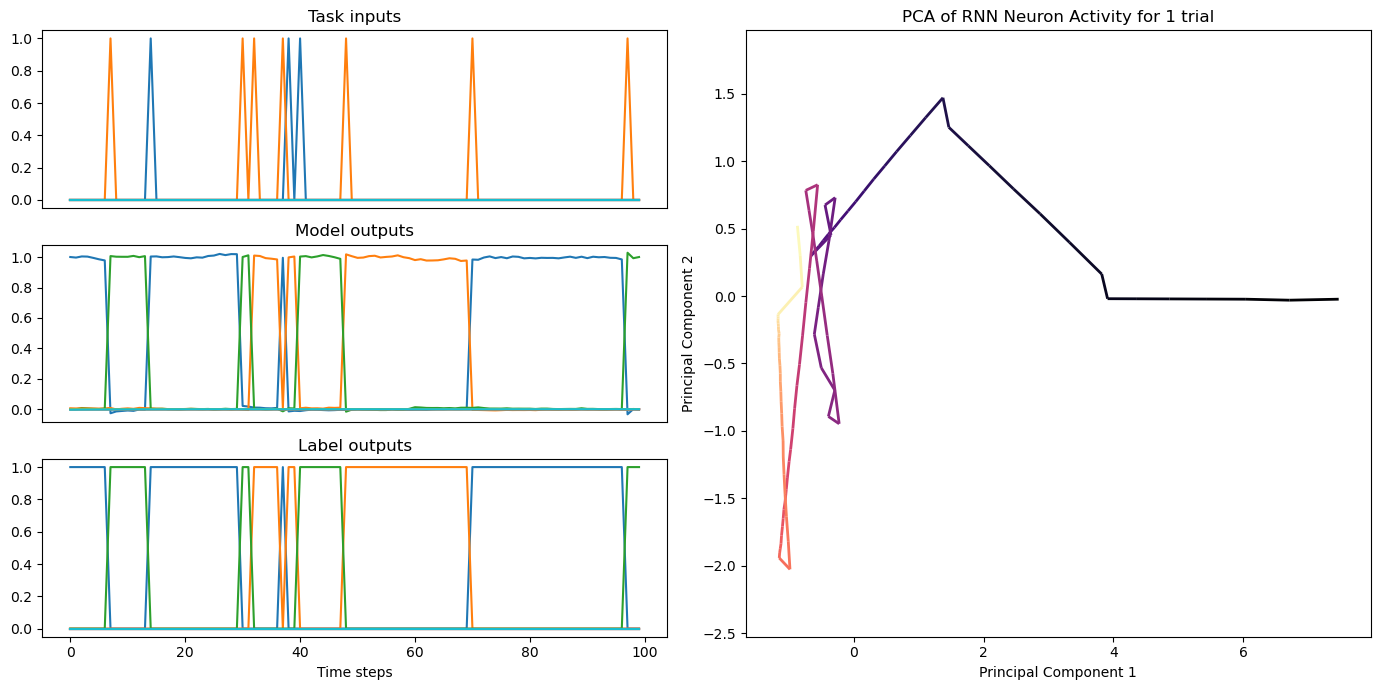

In [7]:
fig = plt.figure(figsize=(14, 7))
gs = GridSpec(3, 2,)

# Panel 1: Task Inputs
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(inputs_[0, :, 10:])
ax1.set_title('Task inputs')
ax1.set_xticks([])

# Panel 2: Model Outputs
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(outputs_[0, :, :])
ax2.set_title('Model outputs')
ax2.set_xticks([])

# Panel 3: Label Outputs
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(labels_[0, :, :])
ax3.set_title('Label outputs')
ax3.set_xlabel('Time steps')

# Panel 4: PCA of RNN Neuron Activity
ax4 = fig.add_subplot(gs[:, 1])

x = reshaped_pc[0, :, 0]
y = reshaped_pc[0, :, 1]

points = jnp.array([x, y]).T.reshape(-1, 1, 2)
segments = jnp.concatenate([points[:-1], points[1:]], axis=1)

cmap = plt.get_cmap('magma')
norm = Normalize(0, len(x)-1)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(jnp.arange(len(x)-1))
lc.set_linewidth(2)

ax4.add_collection(lc)
ax4.set_xlim(x.min()-0.5, x.max()+0.5)
ax4.set_ylim(y.min()-0.5, y.max()+0.5)
#plt.colorbar(lc, ax=ax4, label='Index along trajectory')
ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')
ax4.set_title('PCA of RNN Neuron Activity for 1 trial')

plt.tight_layout()
plt.show()

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(14, 7))
gs = GridSpec(3, 2)

# Panel 1: Task Inputs
ax1 = fig.add_subplot(gs[0, 0])
line1, = ax1.plot([], [], 'o-', color='blue')
ax1.set_title('Task inputs')
ax1.set_xticks([])

# Panel 2: Model Outputs
ax2 = fig.add_subplot(gs[1, 0])
line2, = ax2.plot([], [], 'o-', color='green')
ax2.set_title('Model outputs')
ax2.set_xticks([])

# Panel 3: Label Outputs
ax3 = fig.add_subplot(gs[2, 0])
line3, = ax3.plot([], [], 'o-', color='magenta')
ax3.set_title('Label outputs')
ax3.set_xlabel('Time steps')

# Panel 4: PCA of RNN Neuron Activity
ax4 = fig.add_subplot(gs[:, 1])
x = reshaped_pc[0, :, 0]
y = reshaped_pc[0, :, 1]
points = jnp.array([x, y]).T
line4, = ax4.plot([], [], 'o', color='red')
ax4.set_xlim(x.min()-0.5, x.max()+0.5)
ax4.set_ylim(y.min()-0.5, y.max()+0.5)
ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')
ax4.set_title('PCA of RNN Neuron Activity for 1 trial')

def update(frame):
    # Update each line in all subplots
    line1.set_data(jnp.arange(frame), inputs_[0, :frame, 10:])
    line2.set_data(jnp.arange(frame), outputs_[0, :frame, :])
    line3.set_data(jnp.arange(frame), labels_[0, :frame, :])
    line4.set_data(points[:frame, 0], points[:frame, 1])
    
    return line1, line2, line3, line4

# Total number of frames (should be based on the longest sequence among inputs, outputs, and labels)
num_frames = max(inputs_[0, :, 10:].shape[0], outputs_[0, :, :].shape[0], labels_[0, :, :].shape[0])

# Create the FuncAnimation object
#ani = FuncAnimation(fig, update, frames=num_frames, interval=1000/15, blit=True)
#ani.save('full_rnn_activity.gif', writer='pillow')

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (20,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (20,).

<Figure size 1400x700 with 4 Axes>